In [240]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pyzbar.pyzbar as pyzbar

[]


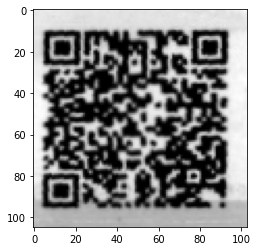

In [242]:
img = cv2.imread('qr/0002.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
barcodes=pyzbar.decode(img)
print(barcodes)
plt.imshow(img, cmap='gray')

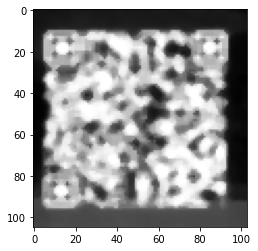

In [243]:
img = 255 - img
blur = cv2.medianBlur(img, 5)
plt.imshow(blur, cmap='gray')

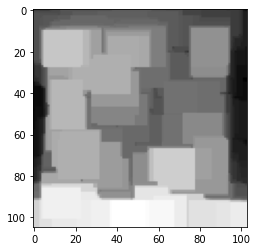

In [244]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(morphed, cmap='gray')

[]


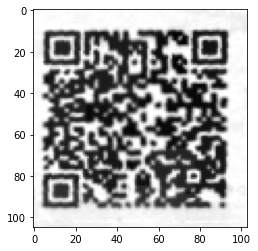

In [245]:
output = 255 - cv2.subtract(img, morphed)
barcodes=pyzbar.decode(output)
print(barcodes)
plt.imshow(output, cmap='gray')

[]


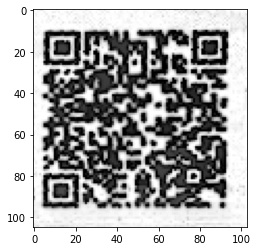

In [246]:
laplacian = cv2.Laplacian(output, -1)
new_img =cv2.subtract(output, laplacian)
barcodes=pyzbar.decode(new_img)
print(barcodes)
plt.imshow(new_img, cmap='gray')

[Decoded(data=b'200087091412511530034667018715167684507415962791635763805933362167467427339290781150856974557013246690526991430482730086132393961481603217718497', type='QRCODE', rect=Rect(left=5, top=10, width=87, height=85), polygon=[Point(x=5, y=94), Point(x=91, y=95), Point(x=92, y=10), Point(x=6, y=10)])]


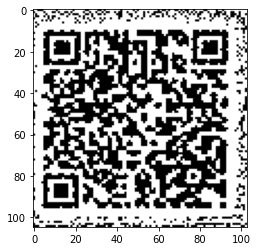

In [247]:
test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
barcodes=pyzbar.decode(test)
print(barcodes)
plt.imshow(test, cmap='gray')

128 [Decoded(data=b'200087091412511530034667018715167684507415962791635763805933362167467427339290781150856974557013246690526991430482730086132393961481603217718497', type='QRCODE', rect=Rect(left=4, top=4, width=109, height=105), polygon=[Point(x=4, y=109), Point(x=112, y=109), Point(x=113, y=5), Point(x=5, y=4)])]


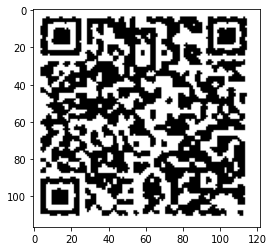

In [35]:
for i in range(127, 256):  #粗暴的阈值处理（可能先通过某种算法调整对比度）
    _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
    barcodes=pyzbar.decode(output2)
    if len(barcodes) != 0:
        break
# _, output2 = cv2.threshold(new_img, 0, 255, cv2.THRESH_OTSU)

print(i, barcodes)
plt.imshow(output2, cmap='gray')

### 一个简单的汇总

In [251]:
def recog_qr(img):
    barcodes=pyzbar.decode(img)
    if len(barcodes) > 0:
        return 0, barcodes[0].data.decode('utf-8')
    
    img = 255 - img
    blur = cv2.medianBlur(img, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    output = 255 - cv2.subtract(img, morphed)
    barcodes=pyzbar.decode(output)
    if len(barcodes) > 0:
        return 1, barcodes[0].data.decode('utf-8')
    
    laplacian = cv2.Laplacian(output, -1)
    new_img =cv2.subtract(output, laplacian)
    barcodes=pyzbar.decode(new_img)
    if len(barcodes) > 0:
        return 2, barcodes[0].data.decode('utf-8')
    
    test = cv2.adaptiveThreshold(new_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    barcodes=pyzbar.decode(test)
    if len(barcodes) > 0:
        return 3, barcodes[0].data.decode('utf-8')
    
    for i in range(127, 256):  #粗暴的阈值处理（可能先通过某种算法调整对比度）
        _, output2 = cv2.threshold(new_img, i, 255, cv2.THRESH_BINARY)
        barcodes=pyzbar.decode(output2)
        if len(barcodes) != 0:
            return 4, barcodes[0].data.decode('utf-8')
    else:
        return -1, ''    
    

In [253]:
input_path = 'qr'
output_file = 'predictions.txt'
counter = [0, 0, 0, 0, 0]

with open(output_file, 'w') as f:
    for file_name in tqdm(os.listdir(input_path)):
        img = cv2.imread(os.path.join(input_path, file_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        status, result = recog_qr(img)
        f.write('{} {}\n'.format(file_name, result))
        if status != -1:
            counter[status] += 1

total = sum(counter)
print()
print('Sum*', 'Base', 'T-hat', 'lapla', 'athrs', 'thrs', sep='\t')
print(total, *counter, sep='\t')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.07it/s]
Sum*	Base	T-hat	lapla	athrs	thrs
55	38	5	7	4	1

